In [1]:
%matplotlib inline

import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap

In [2]:
pokemon_df = pd.read_csv("../../data/raw/pokemon/pokemon_alopez247.csv", index_col=0)
pokemon_dm_gower = pd.read_csv("../../data/processed/pokemon_dm_gower.csv", sep=",", index_col=0)
pokemon_dm_gower_cat = pd.read_csv("../../data/processed/pokemon_dm_gower_only_categorical.csv", sep=",", index_col=0)
pokemon_df = pokemon_df.reset_index(drop=True)
for col in pokemon_df.columns:
    if pokemon_df[col].dtype == 'bool':
        pokemon_df[col] = pokemon_df[col].astype(str)
pokemon_df.head()

Name Type_1  Type_2  Total  HP  Attack  Defense  Sp_Atk  Sp_Def  \
0   Bulbasaur  Grass  Poison    318  45      49       49      65      65   
1     Ivysaur  Grass  Poison    405  60      62       63      80      80   
2    Venusaur  Grass  Poison    525  80      82       83     100     100   
3  Charmander   Fire     NaN    309  39      52       43      60      50   
4  Charmeleon   Fire     NaN    405  58      64       58      80      65   

   Speed  ...  Color hasGender Pr_Male Egg_Group_1  Egg_Group_2  \
0     45  ...  Green      True   0.875     Monster        Grass   
1     60  ...  Green      True   0.875     Monster        Grass   
2     80  ...  Green      True   0.875     Monster        Grass   
3     65  ...    Red      True   0.875     Monster       Dragon   
4     80  ...    Red      True   0.875     Monster       Dragon   

  hasMegaEvolution Height_m Weight_kg  Catch_Rate      Body_Style  
0            False     0.71       6.9          45       quadruped  
1            False     0.99      13.0          45       quadruped  
2             True     2.01     100.0          45       quadruped  
3            False     0.61       8.5          45  bipedal_tailed  
4            False     1.09      19.0          45  bipedal_tailed  

[5 rows x 22 columns]

In [3]:
def fill_type2(row):
    if str(row["Type_2"]) == 'nan':
        return row["Type_1"]
    else:
        return row["Type_2"]
    
def fill_egg_group2(row):
    if str(row["Egg_Group_2"]) == 'nan':
        return row["Egg_Group_1"]
    else:
        return row["Egg_Group_2"]
    
pokemon_df["Type_2"] = pokemon_df.apply(fill_type2, 1)
pokemon_df["Egg_Group_2"] = pokemon_df.apply(fill_egg_group2, 1)
pokemon_df.head()

Name Type_1  Type_2  Total  HP  Attack  Defense  Sp_Atk  Sp_Def  \
0   Bulbasaur  Grass  Poison    318  45      49       49      65      65   
1     Ivysaur  Grass  Poison    405  60      62       63      80      80   
2    Venusaur  Grass  Poison    525  80      82       83     100     100   
3  Charmander   Fire    Fire    309  39      52       43      60      50   
4  Charmeleon   Fire    Fire    405  58      64       58      80      65   

   Speed  ...  Color hasGender Pr_Male Egg_Group_1  Egg_Group_2  \
0     45  ...  Green      True   0.875     Monster        Grass   
1     60  ...  Green      True   0.875     Monster        Grass   
2     80  ...  Green      True   0.875     Monster        Grass   
3     65  ...    Red      True   0.875     Monster       Dragon   
4     80  ...    Red      True   0.875     Monster       Dragon   

  hasMegaEvolution Height_m Weight_kg  Catch_Rate      Body_Style  
0            False     0.71       6.9          45       quadruped  
1            False     0.99      13.0          45       quadruped  
2             True     2.01     100.0          45       quadruped  
3            False     0.61       8.5          45  bipedal_tailed  
4            False     1.09      19.0          45  bipedal_tailed  

[5 rows x 22 columns]

In [4]:
all_egg_groups = set(pokemon_df["Egg_Group_1"]) & set(pokemon_df["Egg_Group_2"])
all_egg_groups = sorted(all_egg_groups)

def get_either_param(row, param1, param2, value):
    """Return whether Pokemon has value in param.
    
    Parameters:
    -----------
        row: single row from pd.DataFrame.iterrows()
        param1: first column to check
        param2: second column to check
        value: value in column to associate
    
    Returns:
    --------
        value/other: if value is present in row, return it
            else, return "other"
    
    Usage:
    ------
        df["color"] = df.apply(
            get_either_param, 
            1, 
            param1="Egg_Group_1",
            param2="Egg_Group_2",
            value="Amorphous",
        )
    
    """
    if row[param1] == value or row[param2] == value:
        return value
    else:
        return "other"

def plot_egg_group_sns(
    umap_results: np.ndarray, 
    suptitle: str,
    figsize: tuple = (20, 10),
    save_location: str = None,
    subplot_kw: dict = None,
    **kwargs,
):
    df = pd.DataFrame(umap_results, columns=["x", "y"]).join(pokemon_df)
    plt.rcParams["font.family"] = "Helvetica"
    plt.rcParams["figure.facecolor"] = "white"
    fig, axes = plt.subplots(3, 5, figsize=figsize, dpi=300, subplot_kw={'aspect': 'equal'})
    plt.subplots_adjust(
        **subplot_kw,
        #wspace=0.05, 
        #hspace=0.25,
    )
    
    for i, this_egg_group in enumerate(all_egg_groups): 
        ax = axes.flat[i]
        df["color"] = df.apply(
            get_either_param,
            1,
            param1="Egg_Group_1",
            param2="Egg_Group_2",
            value=this_egg_group)

        sns.scatterplot(
            data=df,
            x="x",
            y="y",
            hue="color",
            s=15,
            palette={this_egg_group: "#484848", "other": "#D3D3D3"},
            legend=False,
            edgecolor="black",
            linewidth=0,
            ax=ax,
            **kwargs,
        )
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_title(this_egg_group.replace("_", " "), fontsize=24)
        plt.suptitle(suptitle, fontsize=30)
        
    if save_location is not None:
        plt.savefig(save_location, dpi=300, bbox_inches="tight")
        
    plt.show()

## Only Numeric Features

In [5]:
pokemon_df_only_num = pokemon_df[['Total', 'HP', 'Attack', 'Defense', 
                                  'Sp_Atk', 'Sp_Def', 'Speed', 'Height_m', 
                                  'Weight_kg', 'Catch_Rate']].reset_index(drop=True)
pokemon_df_only_num.head()

Total  HP  Attack  Defense  Sp_Atk  Sp_Def  Speed  Height_m  Weight_kg  \
0    318  45      49       49      65      65     45      0.71        6.9   
1    405  60      62       63      80      80     60      0.99       13.0   
2    525  80      82       83     100     100     80      2.01      100.0   
3    309  39      52       43      60      50     65      0.61        8.5   
4    405  58      64       58      80      65     80      1.09       19.0   

   Catch_Rate  
0          45  
1          45  
2          45  
3          45  
4          45

In [6]:
reducer_only_num = umap.UMAP(min_dist=0.4, n_neighbors=8, random_state=42)
embedding_only_num = reducer_only_num.fit_transform(pokemon_df_only_num)

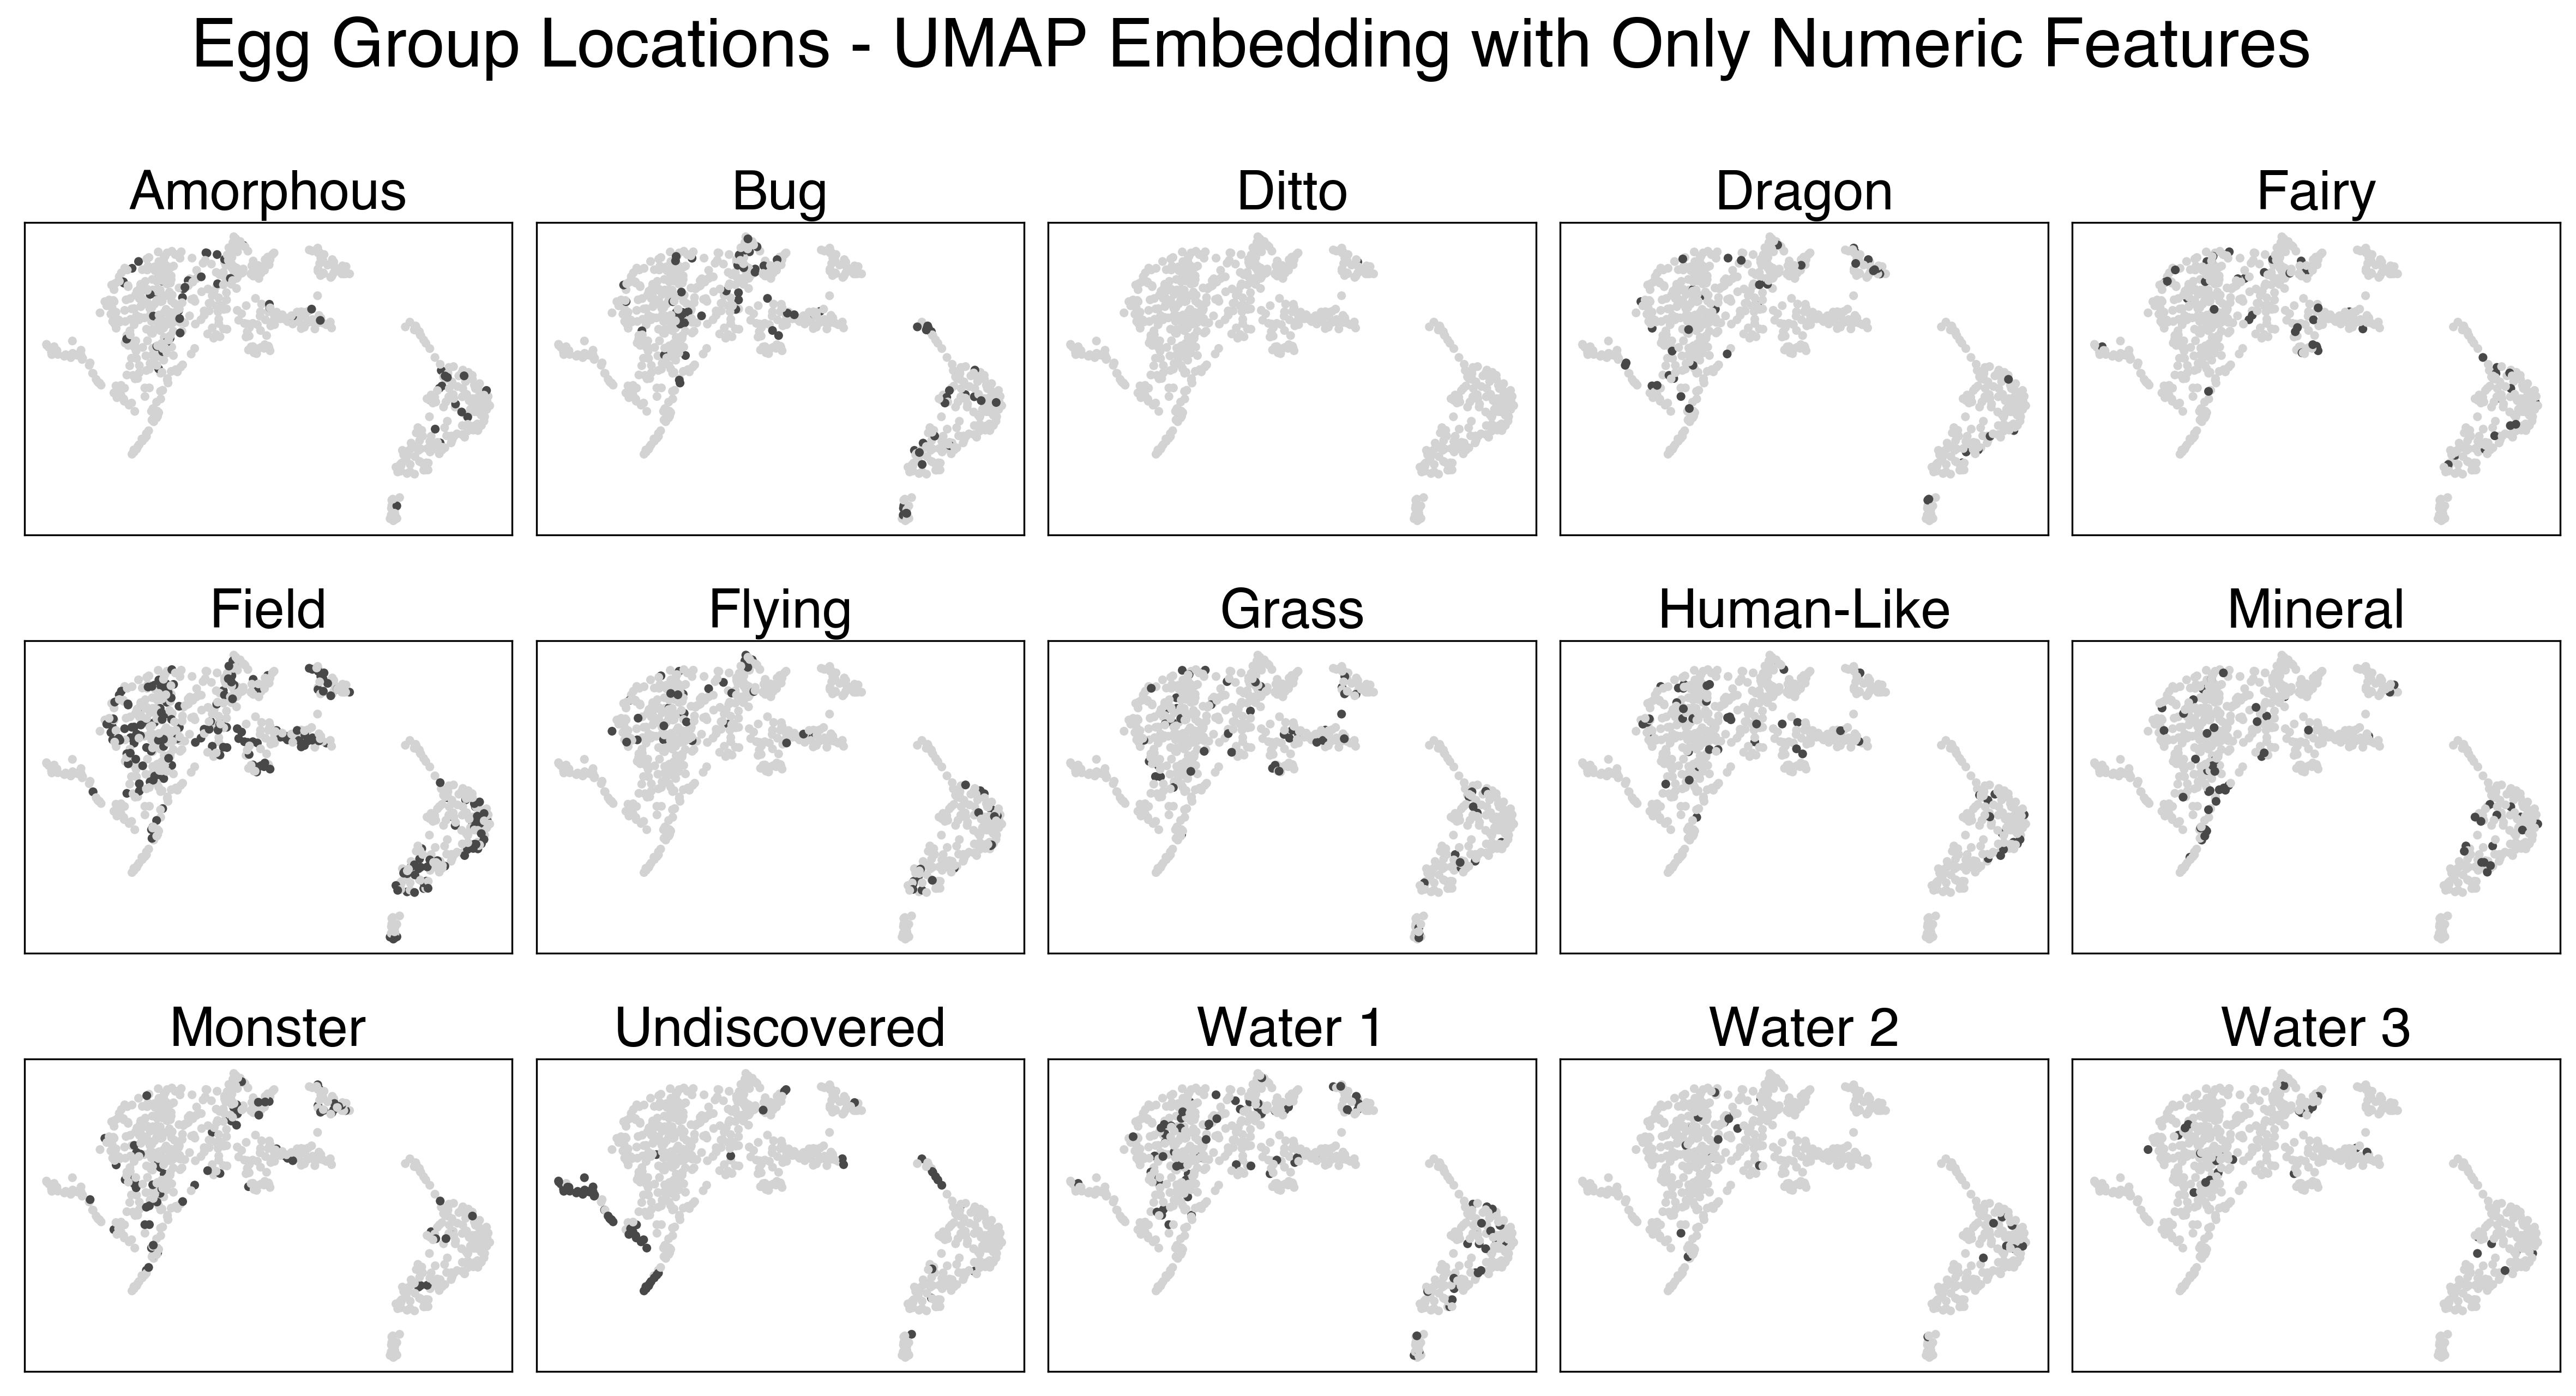

In [7]:
plot_egg_group_sns(
    embedding_only_num, 
    "Egg Group Locations - UMAP Embedding with Only Numeric Features",
    subplot_kw={"wspace": 0.05, "hspace": 0.05},
    #figsize=(15, 20),
    save_location = "only_numeric_egg_group.png",
)

# Only Categorical Features

In [8]:
reducer_only_cat = umap.UMAP(metric="precomputed", min_dist=0.4, n_neighbors=8, random_state=42)
embedding_only_cat = reducer_only_cat.fit_transform(pokemon_dm_gower_cat)

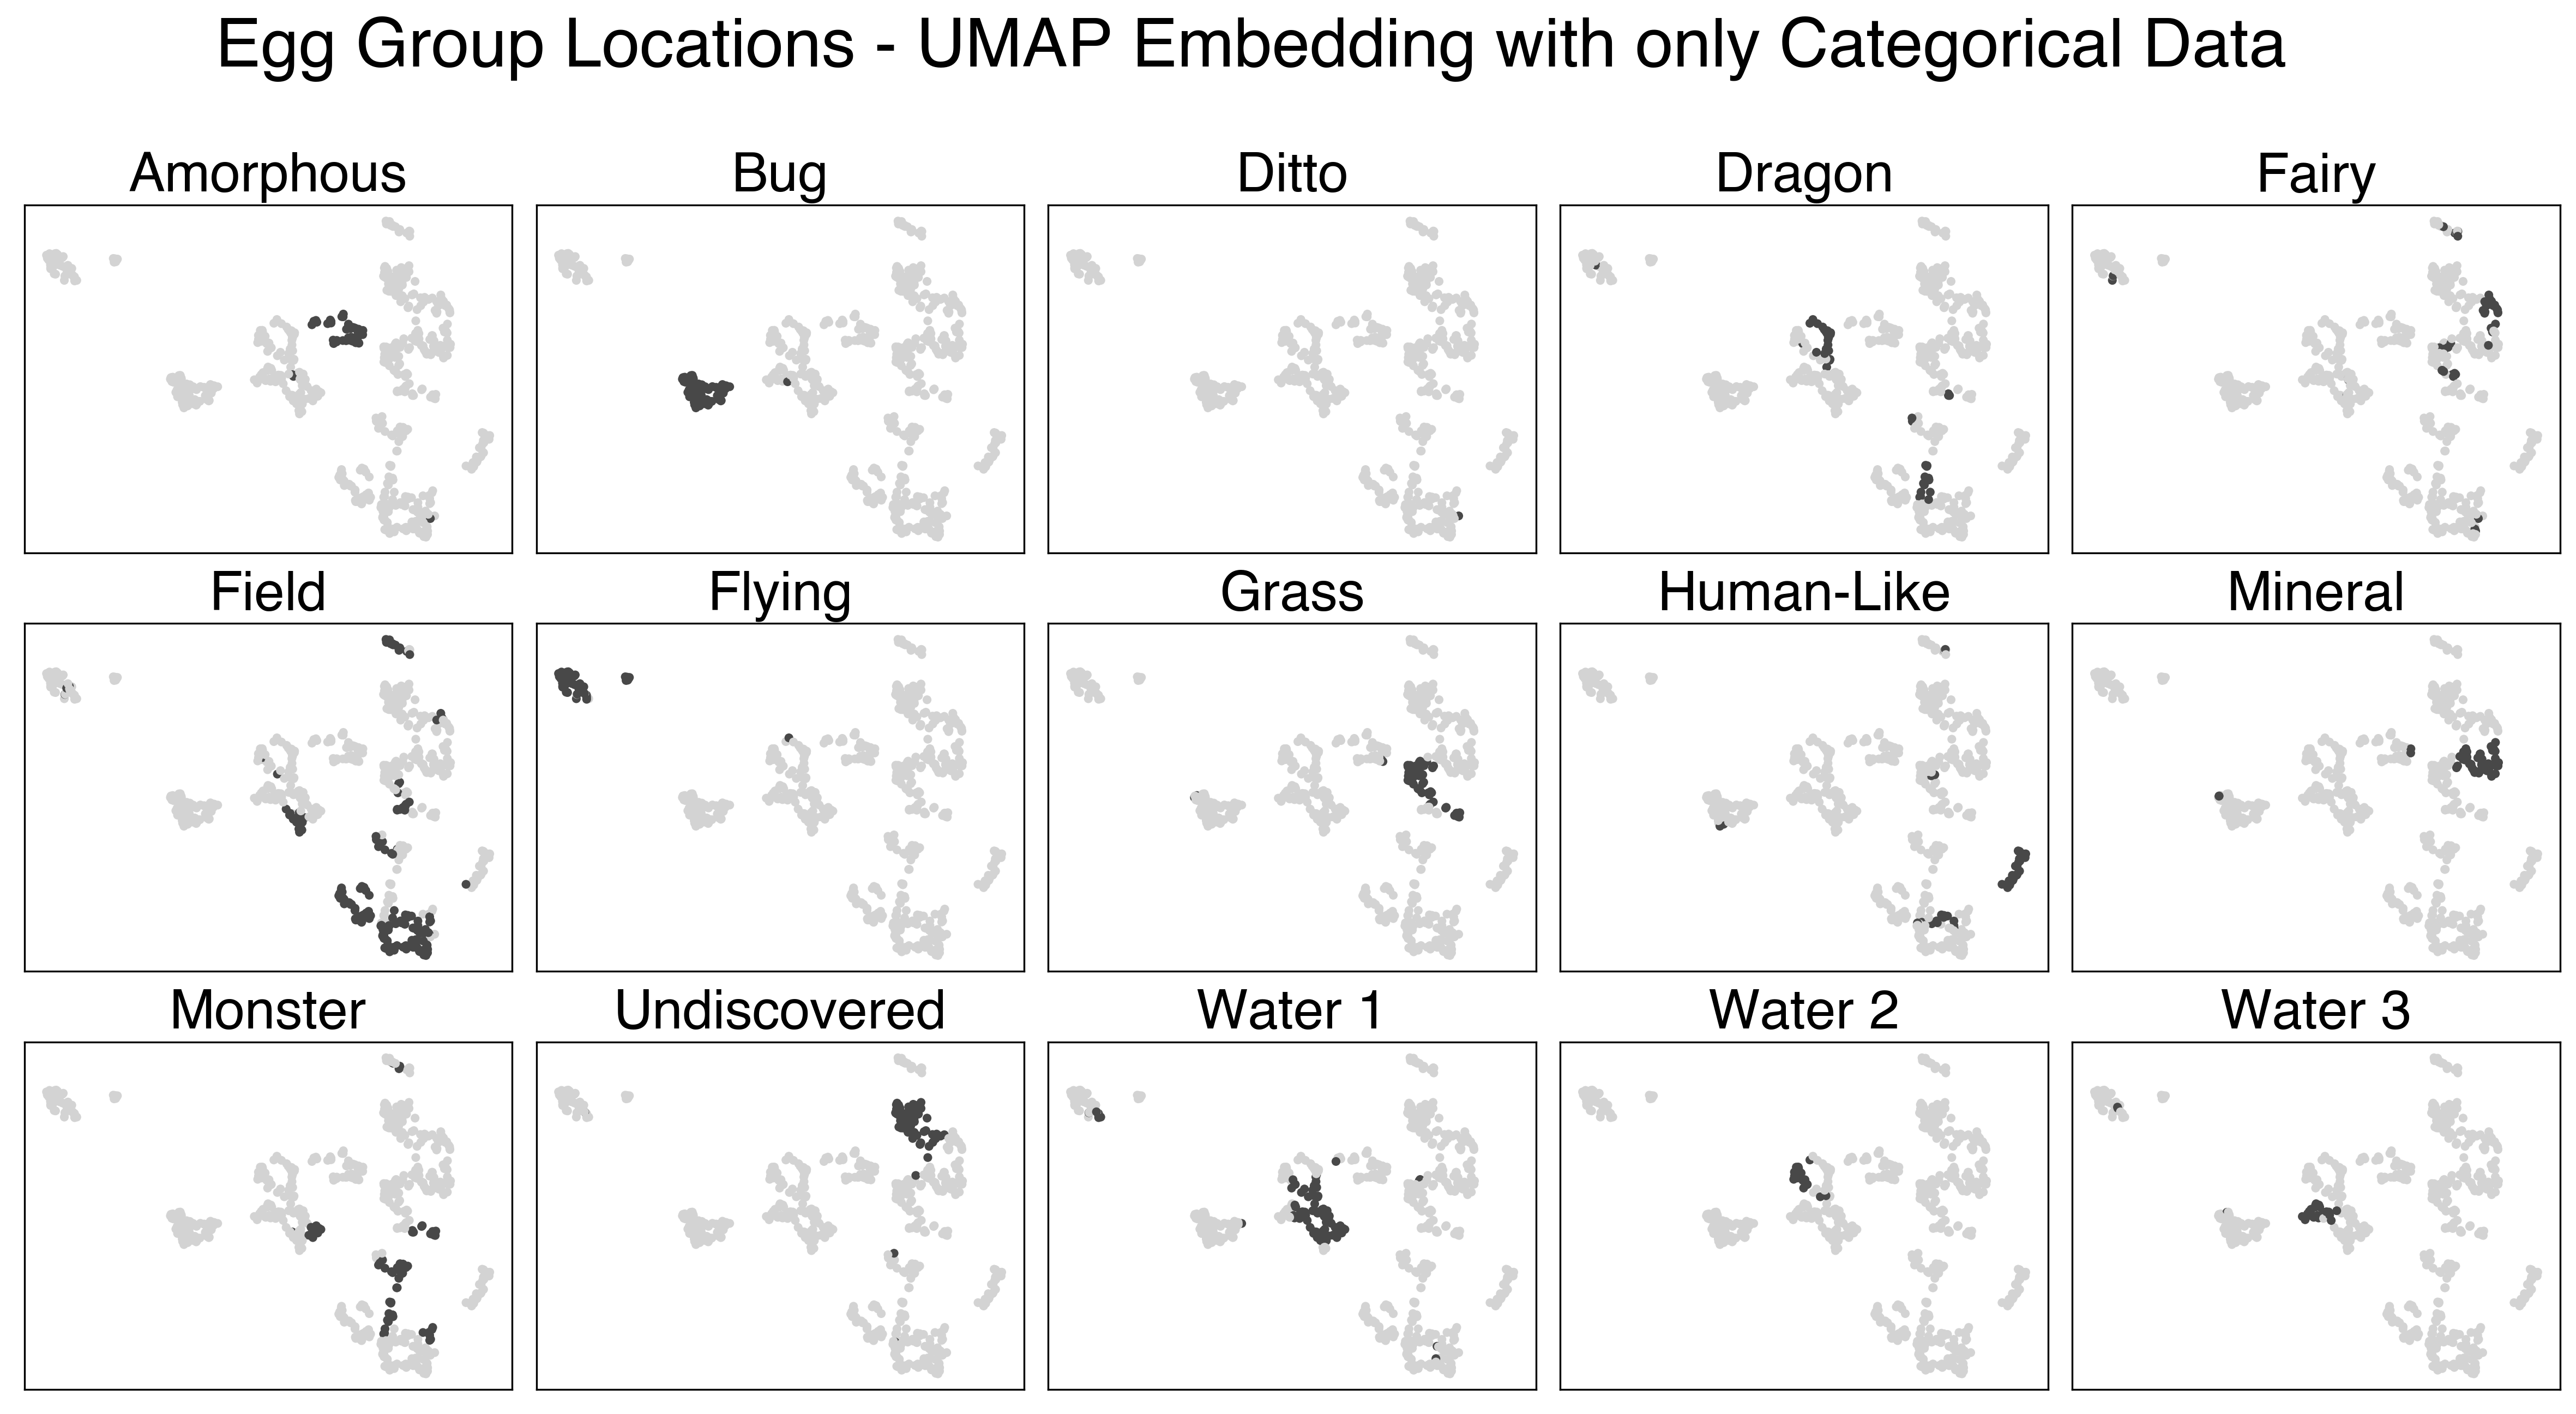

In [9]:
plot_egg_group_sns(
    embedding_only_cat, 
    "Egg Group Locations - UMAP Embedding with only Categorical Data", 
    save_location = "only_cat_egg_group.png",
    subplot_kw={"wspace": 0.05, "hspace": 0.05},
)

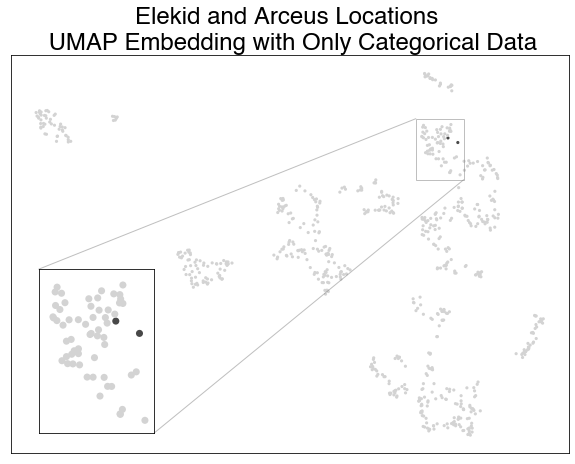

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df = pd.DataFrame(embedding_only_cat, columns=["x", "y"]).join(pokemon_df)
df["color"] = df.apply(lambda x: x["Name"] in ["Elekid", "Arceus"], axis=1)
df_zoom = df.loc[
    (df["x"] > 4.75) & (df["x"] < 7.5) & (df["y"] > -2.5) & (df["y"] < 1), :
]

fig, ax_big = plt.subplots(
    1, 1, 
    figsize=(10, 8), 
    subplot_kw={"aspect": "equal"},
)
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["figure.facecolor"] = "white"
#plt.rcParams["figure.dpi"] = 300

sns.scatterplot(
    data=df,
    x="x",
    y="y",
    s=10,
    hue="color",
    palette={True: "#484848", False: "#D3D3D3"},
    legend=False,
    linewidth=0,
    edgecolor="black",
    #alpha=0.6,
    ax=ax_big,
)

#axins = inset_axes(ax, width=(7.5-4.75)*0.5, height=(1+2.5)*0.5, loc=3)
axins = ax_big.inset_axes([0.05, 0.05, (7.5 - 4.75) * 0.075, (1 + 4.5) * 0.075])
sns.scatterplot(
    data=df_zoom,
    x="x",
    y="y",
    s=50,
    hue="color",
    palette={True: "#484848", False: "#D3D3D3"},
    legend=False,
    linewidth=0,
    edgecolor="black",
    #alpha=0.6,
    ax=axins,
)

axins.set_xlim([4.75, 7.5])
axins.set_ylim([-2.5, 1])
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)
ax_big.xaxis.set_visible(False)
ax_big.yaxis.set_visible(False)
ax_big.indicate_inset_zoom(axins)
ax_big.set_title("Elekid and Arceus Locations \n UMAP Embedding with Only Categorical Data", fontsize=24)

plt.savefig("elekid_arceus_only_cat.png", dpi=300, bbox_inches="tight")

plt.show()

# gUMAP

In [11]:
reducer_gower = umap.UMAP(metric="precomputed", min_dist=0.4, n_neighbors=8, random_state=42)
embedding_gower = reducer_gower.fit_transform(pokemon_dm_gower)

In [12]:
df = pd.DataFrame(embedding_gower, columns=["x", "y"]).join(pokemon_df)
df.head()

x         y        Name Type_1  Type_2  Total  HP  Attack  Defense  \
0 -4.978108 -5.866829   Bulbasaur  Grass  Poison    318  45      49       49   
1 -4.897075 -5.887284     Ivysaur  Grass  Poison    405  60      62       63   
2 -4.817234 -5.744261    Venusaur  Grass  Poison    525  80      82       83   
3 -3.864975 -4.339019  Charmander   Fire    Fire    309  39      52       43   
4 -3.794139 -4.329369  Charmeleon   Fire    Fire    405  58      64       58   

   Sp_Atk  ...  Color  hasGender  Pr_Male Egg_Group_1 Egg_Group_2  \
0      65  ...  Green       True    0.875     Monster       Grass   
1      80  ...  Green       True    0.875     Monster       Grass   
2     100  ...  Green       True    0.875     Monster       Grass   
3      60  ...    Red       True    0.875     Monster      Dragon   
4      80  ...    Red       True    0.875     Monster      Dragon   

  hasMegaEvolution  Height_m Weight_kg Catch_Rate      Body_Style  
0            False      0.71       6.9         45       quadruped  
1            False      0.99      13.0         45       quadruped  
2             True      2.01     100.0         45       quadruped  
3            False      0.61       8.5         45  bipedal_tailed  
4            False      1.09      19.0         45  bipedal_tailed  

[5 rows x 24 columns]

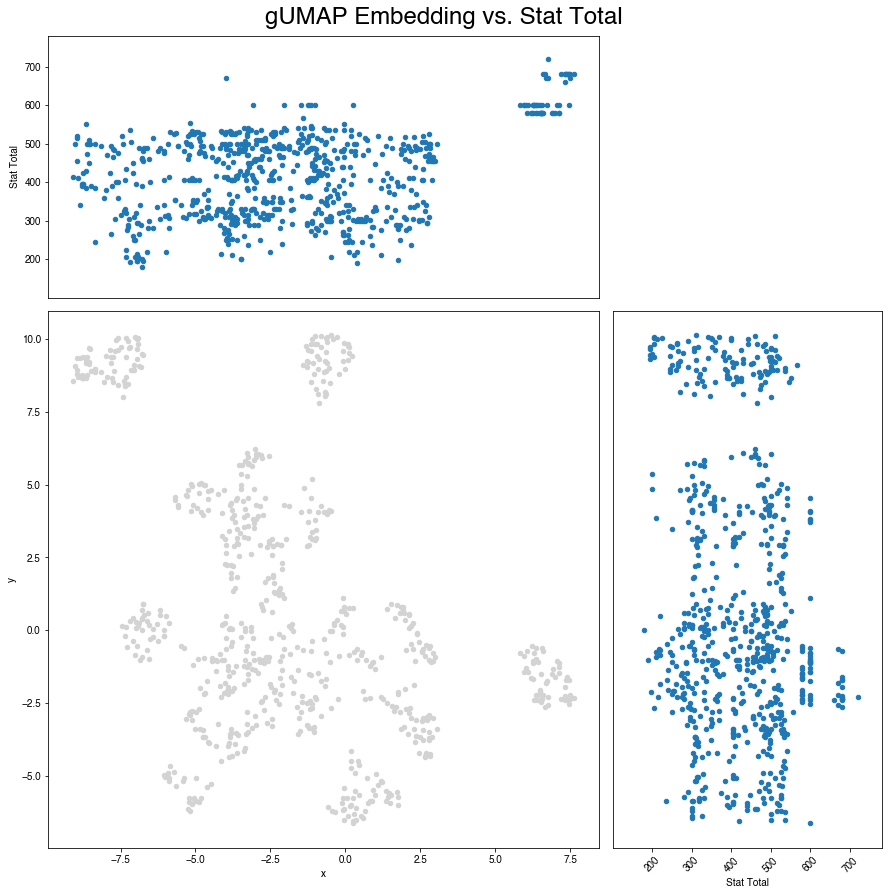

In [13]:
fig = plt.figure(figsize=(20, 20))
ax_scatter = plt.subplot2grid(
    (4, 4), 
    (1, 0), 
    rowspan=2, 
    colspan=2,
    #aspect="equal",
    #xticks=list(),
    #yticks=list(),
)
labels = np.arange(200, 800, 100)
ax_top = plt.subplot2grid(
    (4, 4), 
    (0, 0), 
    colspan=2,
    xticks=list(),
    ylabel="Stat Total",
    ylim=[100, 780],
)
ax_right = plt.subplot2grid(
    (4, 4),
    (1, 2),
    rowspan=2,
    yticks=list(),
    xlabel="Stat Total",
    xlim=[100, 780],
)
ax_right.set_xticks(labels)
ax_right.set_xticklabels(
    labels, 
    rotation=45,
    ha="center",
)

ax_top.set_yticks(labels)
ax_top.set_yticklabels(
    labels, 
    #rotation=45,
)

plt.subplots_adjust(wspace=0.05, hspace=0.05)

ax_scatter.scatter(
    df["x"],
    df["y"],
    s=20,
    c="lightgray",
)
ax_scatter.set_xlabel("x"); ax_scatter.set_ylabel("y")

ax_top.scatter(
    df["x"],
    df["Total"],
    s=20,
)

ax_right.scatter(
    df["Total"],
    df["y"],
    s=20,
)


plt.suptitle("gUMAP Embedding vs. Stat Total", x=0.4, y=0.90, fontsize=24)
plt.savefig("gUMAP_stat_total.png", dpi=300, bbox_inches="tight")
plt.show()

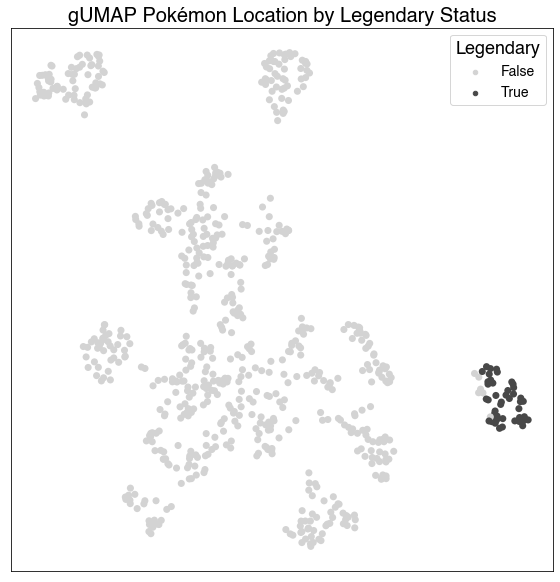

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={"aspect": "equal"})

sns.scatterplot(
    data=df,
    x="x",
    y="y",
    s=50,
    hue="isLegendary",
    palette={"True": "#484848", "False":"#D3D3D3"},
    linewidth=0,
    ax=ax,
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[1:],
    labels[1:],
    title="Legendary",
    markerscale=0.75,
    title_fontsize=18,
    fontsize=14,
)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.title("gUMAP Pokémon Location by Legendary Status", fontsize=20)
plt.savefig("gUMAP_legendary.png", dpi=300, bbox_inches="tight")
plt.show()

## One-Hot Encoding

In [15]:
cat_columns = ["Color", "Body_Style"]
encoding_df_list = list()
for col in cat_columns:
    col_encoded_df = pokemon_df[col].str.get_dummies()
    encoding_df_list.append(col_encoded_df)
type_encoding_df = pokemon_df["Type_1"].str.get_dummies() + pokemon_df["Type_2"].str.get_dummies()
type_encoding_df.columns += '_Type'
egg_group_encoding_df = pokemon_df["Egg_Group_1"].str.get_dummies() + pokemon_df["Egg_Group_2"].str.get_dummies()
egg_group_encoding_df.columns += '_EG'
encoding_df_list += [type_encoding_df, egg_group_encoding_df]
encoding_df = pd.concat(encoding_df_list, axis=1)
encoding_df = pokemon_df.join(encoding_df)
encoding_df.drop(
    [
        "Type_1", "Type_2", "Color", "Body_Style", "Egg_Group_1", "Egg_Group_2",
        "Name", "Pr_Male", "Generation"
    ], 
    inplace=True, 
    axis=1
)

def str2bool(value: str) -> bool: return value == "True"

encoding_df["isLegendary"] = encoding_df["isLegendary"].apply(str2bool)
encoding_df["hasMegaEvolution"] = encoding_df["hasMegaEvolution"].apply(str2bool)
encoding_df["hasGender"] = encoding_df["hasGender"].apply(str2bool)
encoding_df = encoding_df.astype(int)

In [16]:
encoding_df.head()

Total  HP  Attack  Defense  Sp_Atk  Sp_Def  Speed  isLegendary  hasGender  \
0    318  45      49       49      65      65     45            0          1   
1    405  60      62       63      80      80     60            0          1   
2    525  80      82       83     100     100     80            0          1   
3    309  39      52       43      60      50     65            0          1   
4    405  58      64       58      80      65     80            0          1   

   hasMegaEvolution  ...  Field_EG  Flying_EG  Grass_EG  Human-Like_EG  \
0                 0  ...         0          0         1              0   
1                 0  ...         0          0         1              0   
2                 1  ...         0          0         1              0   
3                 0  ...         0          0         0              0   
4                 0  ...         0          0         0              0   

   Mineral_EG  Monster_EG  Undiscovered_EG  Water_1_EG  Water_2_EG  Water_3_EG  
0           0           1                0           0           0           0  
1           0           1                0           0           0           0  
2           0           1                0           0           0           0  
3           0           1                0           0           0           0  
4           0           1                0           0           0           0  

[5 rows x 70 columns]

In [17]:
reducer_encoding = umap.UMAP(min_dist=0.4, n_neighbors=8, random_state=42, metric="manhattan")
embedding_encoding = reducer_encoding.fit_transform(encoding_df)

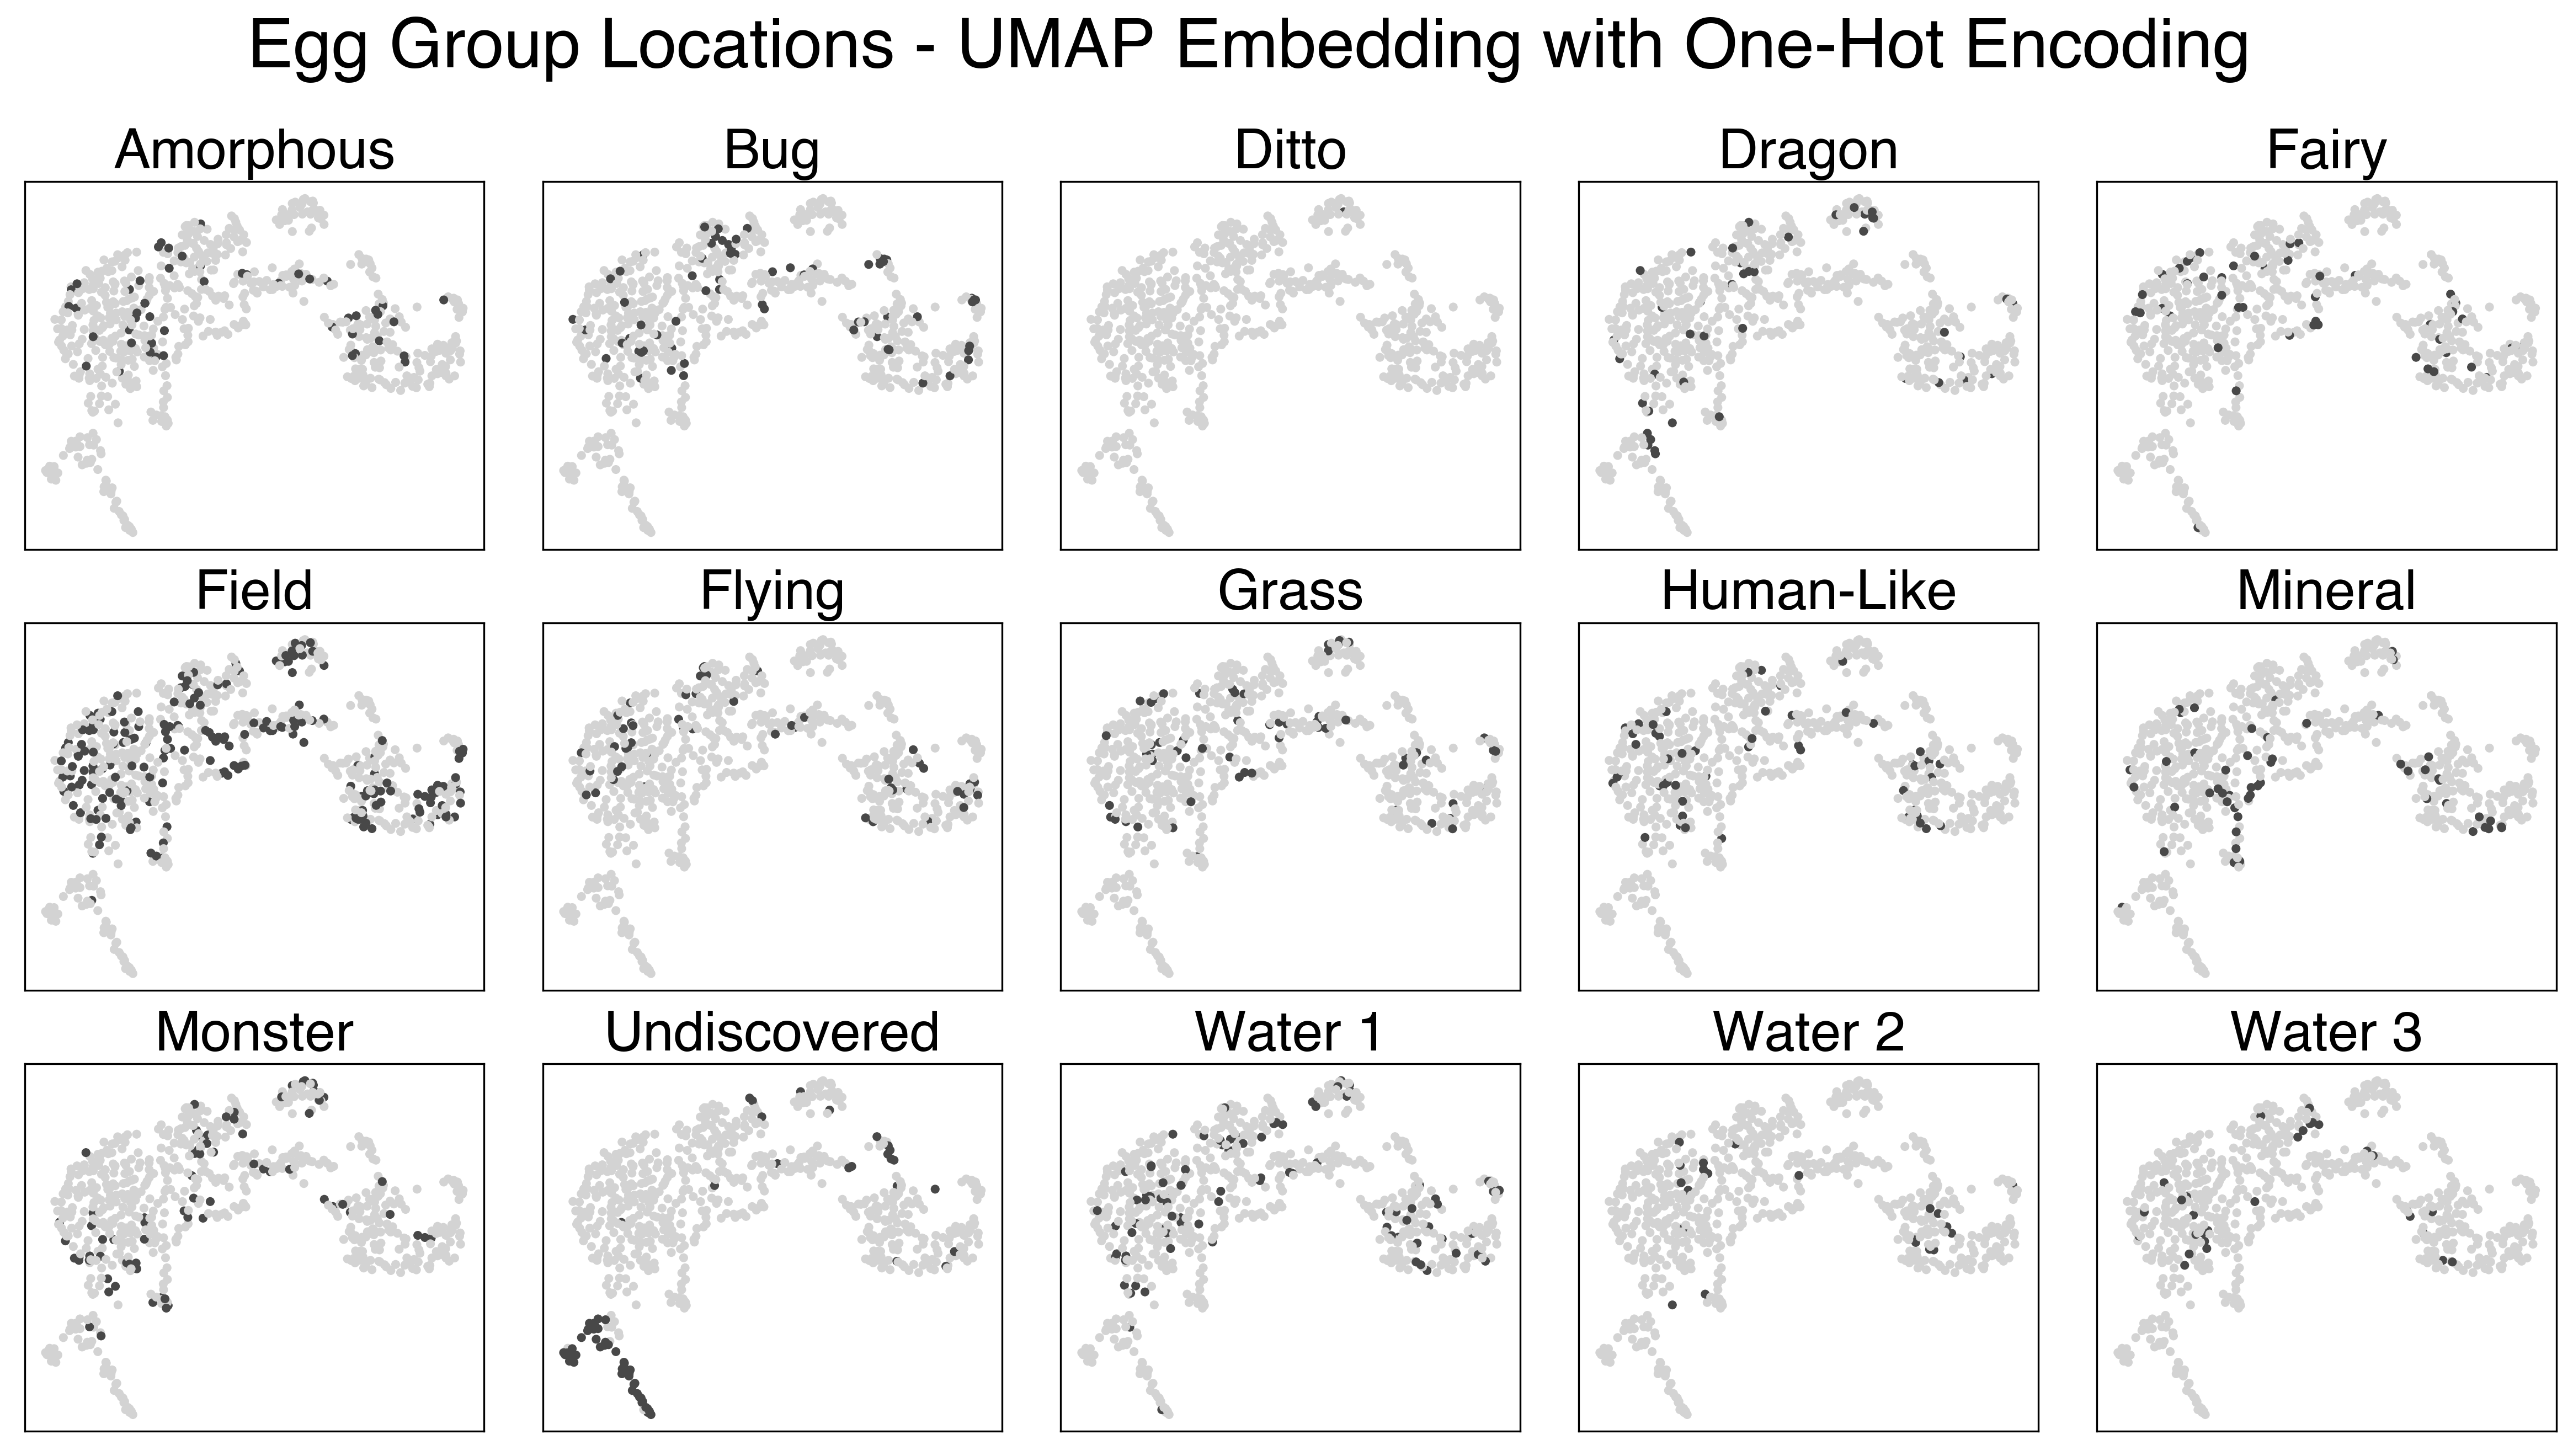

In [18]:
plot_egg_group_sns(
    embedding_encoding, 
    "Egg Group Locations - UMAP Embedding with One-Hot Encoding", 
    save_location = "one_hot_egg_group.png",
    subplot_kw={"wspace": 0.05, "hspace": 0.2},
)

## Amphibian Data

In [19]:
amp_data = pd.read_csv("../../data/raw/amp_data.csv", index_col=0)
amp_gower = pd.read_csv("../../data/processed/amp_gower.csv", index_col=0)
amp_data.head()

Order    Family         Genus  Body_size_mm  Reproductive_output_y  \
2  Anura  Alytidae        Alytes          50.0                    4.0   
5  Anura  Alytidae        Alytes          40.0                    1.0   
6  Anura  Alytidae        Alytes          55.0                    4.0   
7  Anura  Alytidae  Discoglossus          80.0                    6.0   
9  Anura  Alytidae  Discoglossus          65.0                    1.0   

   Offspring_size_min_mm  Offspring_size_max_mm Habitat   Diel Breeding  
2                    2.6                    3.5     Arb    Noc      Lar  
5                    5.4                    7.0     Arb    Noc      Lar  
6                    2.6                    5.0     Arb  Crepu      Lar  
7                    1.5                    2.0     Aqu    Noc      Lar  
9                    1.5                    1.5     Aqu    Noc      Lar

In [20]:
reducer_amp_gower = umap.UMAP(metric="precomputed", random_state=42)
embedding_amp = reducer_amp_gower.fit_transform(amp_gower)

In [21]:
amp_embedding_df = pd.DataFrame(embedding_amp, columns=["x", "y"], index=amp_data.index).join(amp_data)
amp_embedding_df.head()

x         y  Order    Family         Genus  Body_size_mm  \
2 -2.945126 -3.671480  Anura  Alytidae        Alytes          50.0   
5 -2.207141 -3.475926  Anura  Alytidae        Alytes          40.0   
6 -5.608830 -0.675810  Anura  Alytidae        Alytes          55.0   
7 -0.488745  6.204636  Anura  Alytidae  Discoglossus          80.0   
9 -0.578932  6.283576  Anura  Alytidae  Discoglossus          65.0   

   Reproductive_output_y  Offspring_size_min_mm  Offspring_size_max_mm  \
2                    4.0                    2.6                    3.5   
5                    1.0                    5.4                    7.0   
6                    4.0                    2.6                    5.0   
7                    6.0                    1.5                    2.0   
9                    1.0                    1.5                    1.5   

  Habitat   Diel Breeding  
2     Arb    Noc      Lar  
5     Arb    Noc      Lar  
6     Arb  Crepu      Lar  
7     Aqu    Noc      Lar  
9     Aqu    Noc      Lar

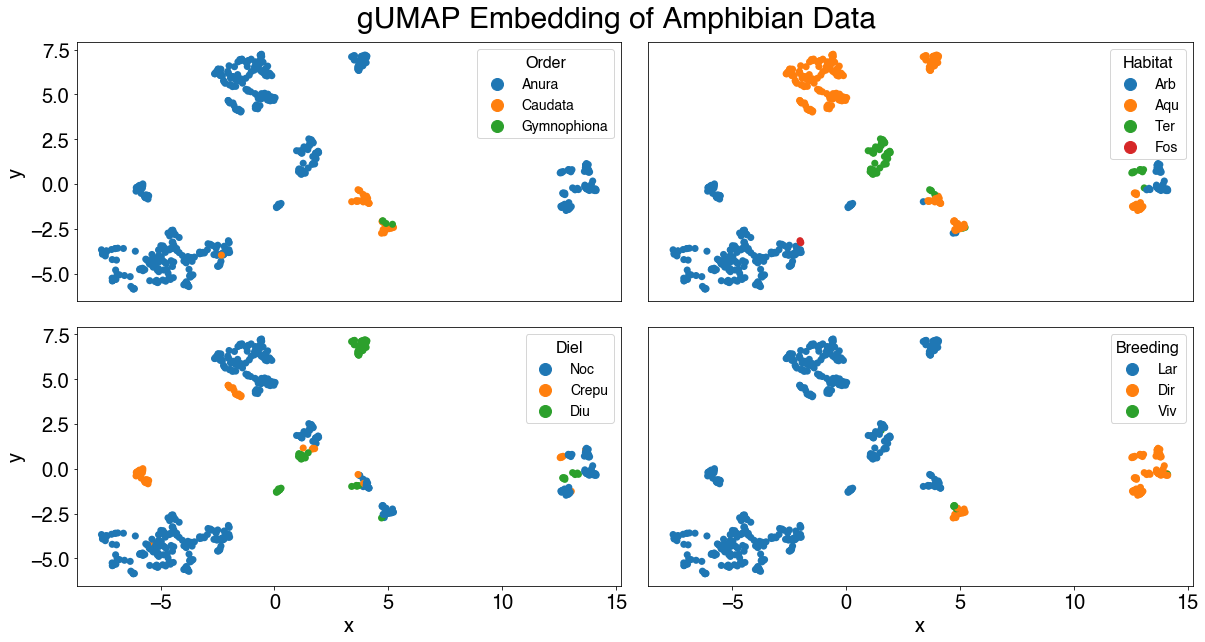

In [22]:
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.labelsize"] = 20
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

for i, col in enumerate(["Order", "Habitat", "Diel", "Breeding"]):
    ax = axes.flat[i]
    sns.scatterplot(
        data=amp_embedding_df,
        x="x",
        y="y",
        s=50,
        hue=col,
        linewidth=0,
        #alpha=0.7,
        ax=ax,
    )
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[1:],
        labels[1:],
        fontsize=14,
        title=col,
        title_fontsize=16,
        markerscale=2,
        loc="upper right",
        #ncol=2,
    )
    
for ax in [axes[0, 0], axes[0, 1]]:
    ax.xaxis.set_visible(False)
for ax in [axes[0, 1], axes[1, 1]]:
    ax.yaxis.set_visible(False)

plt.suptitle("gUMAP Embedding of Amphibian Data", fontsize=30, y=0.93)
plt.savefig("gUMAP_amphibian.png", dpi=300, bbox_inches="tight")

plt.show()

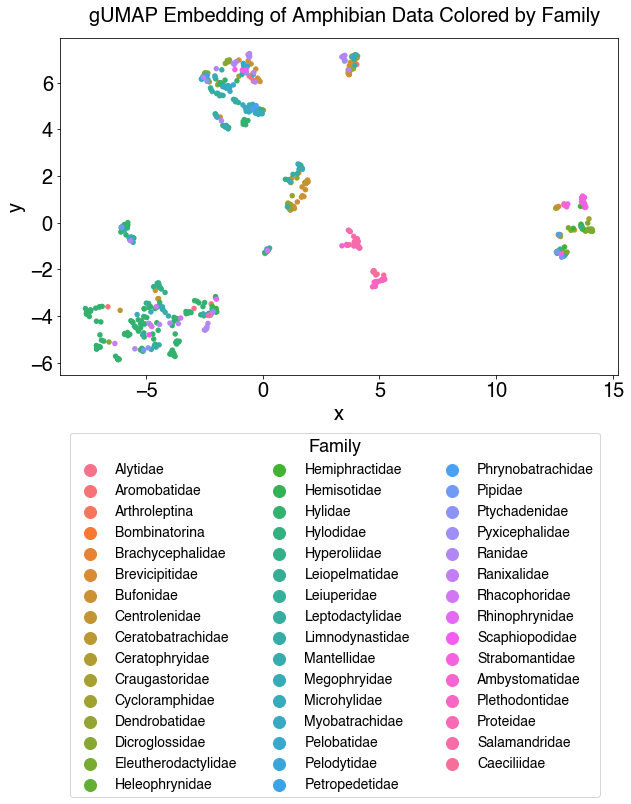

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={"aspect": "equal"})
sns.scatterplot(
    data=amp_embedding_df,
    x="x",
    y="y",
    s=30,
    hue="Family",
    linewidth=0,
    #alpha=0.7,
    ax=ax,
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[1:],
    labels[1:],
    fontsize=14,
    title="Family",
    title_fontsize=18,
    markerscale=2,
    loc="upper right",
    bbox_to_anchor=[0.98, -0.15],
    ncol=3,
)

plt.suptitle("gUMAP Embedding of Amphibian Data Colored by Family", fontsize=20, x=0.52, y=0.78)
plt.savefig("gUMAP_amphibian_family.png", dpi=300, bbox_inches="tight")
plt.show()

## Palm Tree Data

In [24]:
palm_data = pd.read_csv("../../data/raw/palm_data.csv", index_col=0)
palm_gower = pd.read_csv("../../data/processed/palm_gower.csv", index_col=0)
palm_data.head()

accGenus      PalmTribe PalmSubfamily  Climbing  Acaulescent  Erect  \
1  Acoelorrhaphe  Trachycarpeae  Coryphoideae     False        False   True   
2      Acrocomia       Cocoseae    Arecoideae     False        False   True   
3   Actinokentia        Areceae    Arecoideae     False        False   True   
4   Actinorhytis        Areceae    Arecoideae     False        False   True   
5       Aiphanes       Cocoseae    Arecoideae     False        False   True   

   StemSolitary  StemArmed  LeavesArmed  MaxStemHeight_m  MaxStemDia_cm  \
1         False      False         True              9.1           15.0   
2          True       True         True             12.0           50.0   
3          True      False        False              9.0            9.0   
4          True      False        False             40.0           30.0   
5          True       True         True              3.0            6.0   

  UnderstoreyCanopy  Max_Blade_Length_m  AverageFruitLength_cm  \
1            canopy                1.30                   0.70   
2            canopy                3.50                   4.25   
3            canopy                2.35                   2.60   
4            canopy                4.76                  10.00   
5       understorey                1.45                   1.10   

   AverageFruitWidth_cm  MinFruitWidth_cm  MaxFruitWidth_cm  \
1                   0.7               0.5               0.9   
2                   4.6               3.8               5.4   
3                   1.1               0.8               1.4   
4                   5.5               5.0               6.0   
5                   1.1               1.0               1.2   

  FruitSizeCategorical FruitShape MainFruitColors  
1                small      ovoid           black  
2                large      ovoid           green  
3                small    globose             red  
4                large      ovoid             red  
5                small    globose             red

In [25]:
reducer_palm_gower = umap.UMAP(metric="precomputed", random_state=42)
embedding_palm = reducer_palm_gower.fit_transform(palm_gower)

In [26]:
palm_embedding_df = pd.DataFrame(embedding_palm, columns=["x", "y"], index=palm_data.index).join(palm_data)
palm_embedding_df.head()

x         y       accGenus      PalmTribe PalmSubfamily  Climbing  \
1  0.249952 -6.333267  Acoelorrhaphe  Trachycarpeae  Coryphoideae     False   
2 -3.556951 -1.068712      Acrocomia       Cocoseae    Arecoideae     False   
3  2.708658 -1.336324   Actinokentia        Areceae    Arecoideae     False   
4 -0.650303 -1.774742   Actinorhytis        Areceae    Arecoideae     False   
5 -3.499588  0.900533       Aiphanes       Cocoseae    Arecoideae     False   

   Acaulescent  Erect  StemSolitary  StemArmed  ...  MaxStemDia_cm  \
1        False   True         False      False  ...           15.0   
2        False   True          True       True  ...           50.0   
3        False   True          True      False  ...            9.0   
4        False   True          True      False  ...           30.0   
5        False   True          True       True  ...            6.0   

   UnderstoreyCanopy  Max_Blade_Length_m AverageFruitLength_cm  \
1             canopy                1.30                  0.70   
2             canopy                3.50                  4.25   
3             canopy                2.35                  2.60   
4             canopy                4.76                 10.00   
5        understorey                1.45                  1.10   

   AverageFruitWidth_cm  MinFruitWidth_cm  MaxFruitWidth_cm  \
1                   0.7               0.5               0.9   
2                   4.6               3.8               5.4   
3                   1.1               0.8               1.4   
4                   5.5               5.0               6.0   
5                   1.1               1.0               1.2   

   FruitSizeCategorical  FruitShape MainFruitColors  
1                 small       ovoid           black  
2                 large       ovoid           green  
3                 small     globose             red  
4                 large       ovoid             red  
5                 small     globose             red  

[5 rows x 22 columns]

In [27]:
palm_data.columns

Index(['accGenus', 'PalmTribe', 'PalmSubfamily', 'Climbing', 'Acaulescent',
       'Erect', 'StemSolitary', 'StemArmed', 'LeavesArmed', 'MaxStemHeight_m',
       'MaxStemDia_cm', 'UnderstoreyCanopy', 'Max_Blade_Length_m',
       'AverageFruitLength_cm', 'AverageFruitWidth_cm', 'MinFruitWidth_cm',
       'MaxFruitWidth_cm', 'FruitSizeCategorical', 'FruitShape',
       'MainFruitColors'],
      dtype='object')

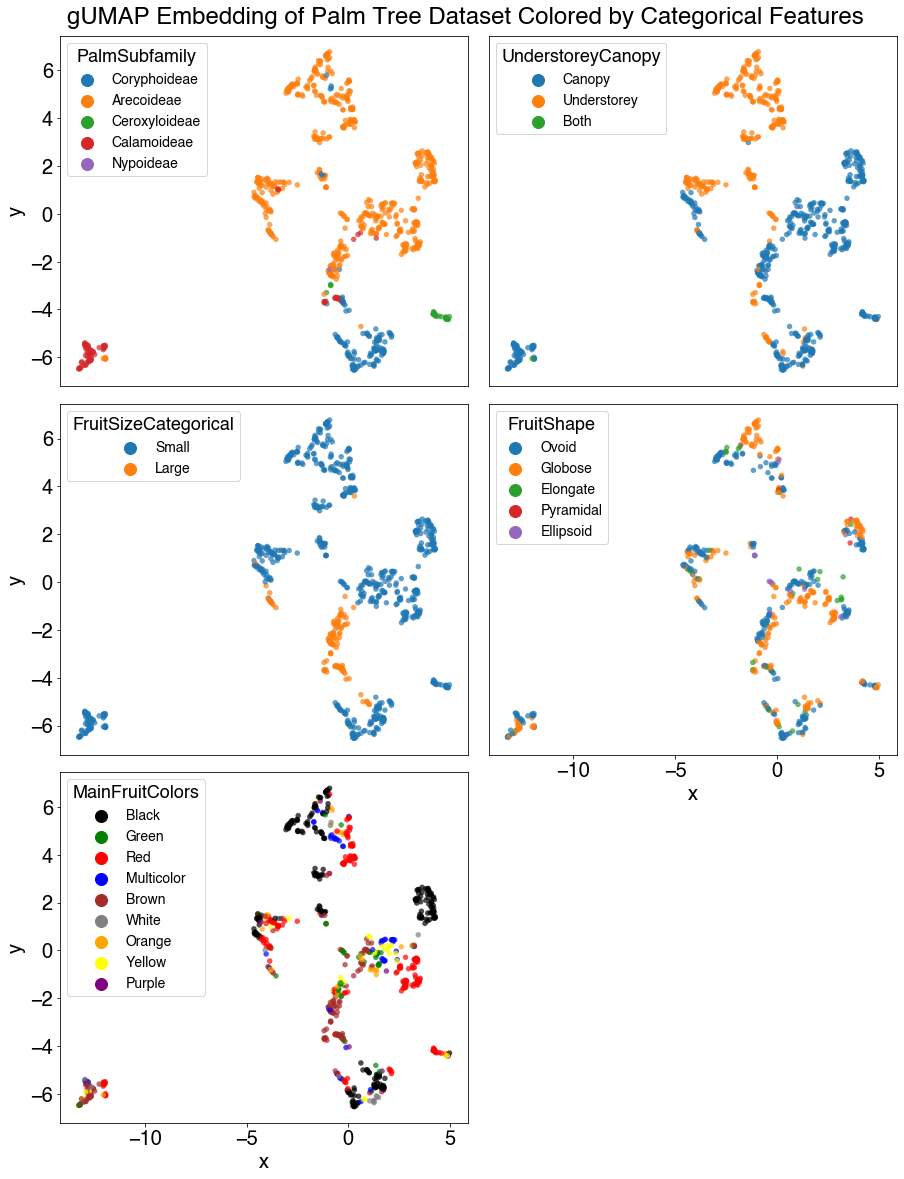

In [28]:
fig, axes = plt.subplots(
    3, 2, 
    figsize=(15, 20), 
    #subplot_kw={"aspect": "equal"},
)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i, col in enumerate(["PalmSubfamily", "UnderstoreyCanopy", "FruitSizeCategorical", "FruitShape", "MainFruitColors"]):
    if col == "MainFruitColors":
        pal = {c:c for c in palm_embedding_df["MainFruitColors"].unique()}
        pal["multicolor"] = "blue"
        pal["white"] = "gray"
    else:
        pal = None
    
    ax = axes.flat[i]
    sns.scatterplot(
        data=palm_embedding_df,
        x="x",
        y="y",
        s=30,
        hue=col,
        palette=pal,
        linewidth=0,
        alpha=0.7,
        ax=ax,
    )

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[1:],
        map(str.capitalize, labels[1:]),
        title=col,
        title_fontsize=18,
        fontsize=14,
        markerscale=2,
    )

for ax in axes[0:2, 0]: ax.xaxis.set_visible(False)
for ax in axes[0:2, 1]: ax.yaxis.set_visible(False)
axes[0, 1].xaxis.set_visible(False)
axes.flat[-1].remove()

plt.suptitle("gUMAP Embedding of Palm Tree Dataset Colored by Categorical Features", fontsize=24, y=0.9)
plt.savefig("gUMAP_palm.png", dpi=300, bbox_inches="tight")
plt.show()

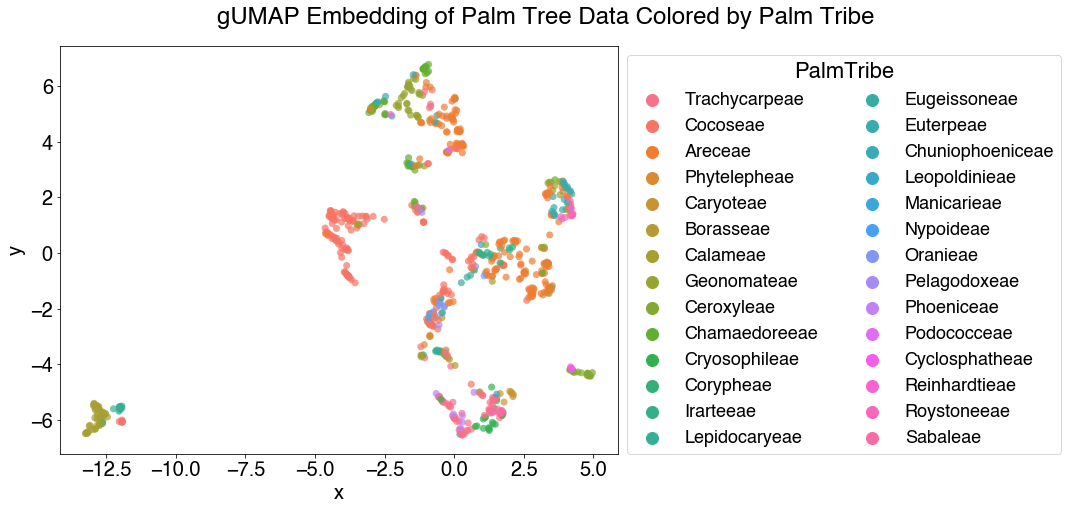

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={"aspect": "equal"})

sns.scatterplot(
    data=palm_embedding_df,
    x="x",
    y="y",
    s=50,
    hue="PalmTribe",
    linewidth=0,
    alpha=0.7,
    ax=ax,
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[1:],
    labels[1:],
    title="PalmTribe",
    title_fontsize=22,
    fontsize=18,
    markerscale=2,
    bbox_to_anchor=[1, 1],
    ncol=2,
)

plt.suptitle("gUMAP Embedding of Palm Tree Data Colored by Palm Tribe", fontsize=24, x=0.8, y=0.84)

plt.savefig("gUMAP_palm_tribe.png", dpi=300, bbox_inches="tight")
plt.show()